Importamos las librerias necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import joypy

Cargamos los datasets

In [2]:
# Dataset con contenido potencialmente lgtbiq+fobico
file_path_orgullo = 'Colectivo.csv'
# Dataset con contenido aleatorio
file_path_espanol = 'Aleatorio.csv'

# cargamos ambos ficheros
df_espanol = pd.read_csv(file_path_espanol)
df_orgullo = pd.read_csv(file_path_orgullo)

In [3]:
# Convertir la columna 'createdAt' a tipo datetime
df_orgullo['createdAt'] = pd.to_datetime(df_orgullo['createdAt'], errors='coerce')
df_espanol['createdAt'] = pd.to_datetime(df_espanol['createdAt'], errors='coerce')

# Crear una columna 'year' a partir de la columna 'createdAt'
df_orgullo['year'] = df_orgullo['createdAt'].dt.year
df_espanol['year'] = df_espanol['createdAt'].dt.year

C:\Users\mar\AppData\Local\Temp\ipykernel_16920\574891241.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orgullo['createdAt'] = pd.to_datetime(df_orgullo['createdAt'], errors='coerce')
C:\Users\mar\AppData\Local\Temp\ipykernel_16920\574891241.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_espanol['createdAt'] = pd.to_datetime(df_espanol['createdAt'], errors='coerce')


# Cantidad de tuits

Sacamos los datasets para cada periodo

In [4]:
# Filtrar el DataFrame en los diferentes grupos de años
df_2015_2019_o = df_orgullo[(df_orgullo['year'] >= 2015) & (df_orgullo['year'] <= 2019)]
df_2020_o = df_orgullo[df_orgullo['year'] == 2020]
df_2021_2022_o = df_orgullo[(df_orgullo['year'] >= 2021) & (df_orgullo['year'] <= 2022)]
df_2023_2024_o = df_orgullo[(df_orgullo['year'] >= 2023) & (df_orgullo['year'] <= 2024)]

In [5]:
# Filtrar el DataFrame en los diferentes grupos de años
df_2015_2019_e = df_espanol[(df_espanol['year'] >= 2015) & (df_espanol['year'] <= 2019)]
df_2020_e = df_espanol[df_espanol['year'] == 2020]
df_2021_2022_e = df_espanol[(df_espanol['year'] >= 2021) & (df_espanol['year'] <= 2022)]
df_2023_2024_e = df_espanol[(df_espanol['year'] >= 2023) & (df_espanol['year'] <= 2024)]

### Dataset Aleatorio Tóxico

Función que nos dará los tuits tóxicos por periodos para un atributo toxicidad dado

In [6]:
# Crear una función para filtrar por tipo de toxicidad
def filter_toxicity(df, toxicity_column, thresholds):
    """
    Filtra el DataFrame por una columna de toxicidad dada y los umbrales de año especificados.
    """
    # Filtrar para los valores dentro de los rangos de años
    df_2015_2019 = df[(df[toxicity_column] > thresholds) & (df['year'] >= 2015) & (df['year'] <= 2019)]
    df_2020 = df[(df[toxicity_column] > thresholds) & (df['year'] == 2020)]
    df_2021_2022 = df[(df[toxicity_column] > thresholds) & (df['year'] >= 2021) & (df['year'] <= 2022)]
    df_2023_2024 = df[(df[toxicity_column] > thresholds) & (df['year'] >= 2023) & (df['year'] <= 2024)]

    return df_2015_2019, df_2020, df_2021_2022, df_2023_2024

Establecemos el threshold a 0.7

In [7]:
threshold_toxicity = 0.7

Sacamos los tuits tóxicos por periodos del dataset Aleatorio 

In [8]:
df_2015_2019_t_e, df_2020_t_e, df_2021_2022_t_e, df_2023_2024_t_e = filter_toxicity(df_espanol, 'toxicity', threshold_toxicity)

Juntamos en una lista de listas los valores de toxicidad y las etiquetas para cada periodo

In [9]:
datasets_e = [
    df_2015_2019_e['toxicity'].values,  # Dataset 1
    df_2020_e['toxicity'].values,       # Dataset 2
    df_2021_2022_e['toxicity'].values,  # Dataset 3
    df_2023_2024_e['toxicity'].values   # Dataset 4
]

datasets_t_e = [
    df_2015_2019_t_e['toxicity'].values,  # Dataset 1
    df_2020_t_e['toxicity'].values,       # Dataset 2
    df_2021_2022_t_e['toxicity'].values,  # Dataset 3
    df_2023_2024_t_e['toxicity'].values   # Dataset 4
]

labels = ['2015-2019', '2020', '2021-2022', '2023-2024']  # Etiquetas para los datasets


Función que me calculará si una lista de datasets son estadísticamente significativos

Kolmogorov-Smirnov

In [10]:
def compare_datasets_with_ks(datasets, labels, fun = stats.ks_2samp):
    """
    Compara varios datasets usando la prueba de Kolmogorov-Smirnov para determinar si provienen de la misma distribución.
    La versión default que usa la función es: "two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x)", 
    si el p-valor es < 0.01 podremos rechazar la hipótesis nula y concluir que las distribuciones son independientes
    
    Parámetros:
    - datasets: Lista de datasets a comparar. Cada dataset debe ser un array o lista de valores.
    - labels: Lista de nombres para los datasets, para mostrar en los resultados.
    
    Devuelve:
    - Una lista de los resultados de las comparaciones (pares de datasets) y los p-valores.
    - Un mensaje indicando si todos los p-valores son menores que 0.01.
    """
    p_values = []
    independent = True  # Flag para verificar si todos los p-valores son menores a 0.01

    # Comparaciones por pares entre los datasets
    for i in range(len(datasets)):
        for j in range(i + 1, len(datasets)):
            # Realizamos la prueba de Kolmogorov-Smirnov (para comparar las distribuciones)
            _, p_value = fun(datasets[i], datasets[j])
            p_values.append((labels[i], labels[j], p_value))
            
            # Verificamos si el p-valor es mayor que 0.01
            if p_value >= 0.01:
                independent = False

    # Imprimir los resultados de las comparaciones
    for comparison in p_values:
        # Desempaquetar los tres elementos de la tupla correctamente
        label_1, label_2, p_value = comparison
        print(f"Comparación entre {label_1} y {label_2}: p-valor = {p_value}")

    # Verificar si todos los p-valores son menores que 0.01
    if independent:
        print("\nTodos los p-valores son menores que 0.01. Los datasets son independientes entre sí.")
    else:
        print("\nAl menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.")


In [11]:
compare_datasets_with_ks([df_orgullo['toxicity'].values, df_espanol['toxicity'].values], ['Colectivo', 'aleatorio'])

Comparación entre Colectivo y aleatorio: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


In [12]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_e, labels)

Comparación entre 2015-2019 y 2020: p-valor = 2.663490521320863e-231
Comparación entre 2015-2019 y 2021-2022: p-valor = 9.852538274696153e-224
Comparación entre 2015-2019 y 2023-2024: p-valor = 0.0
Comparación entre 2020 y 2021-2022: p-valor = 8.03501380072592e-11
Comparación entre 2020 y 2023-2024: p-valor = 4.347820304803495e-52
Comparación entre 2021-2022 y 2023-2024: p-valor = 6.767446561807039e-138

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


Cuartiles perceptiles blabla

In [13]:
def calcular_suma_acumulada(datasets, labels):
    """
    Calcula los cuantiles, moda, y media de varios datasets y los imprime.
    
    Parámetros:
    - datasets: Lista de datasets a comparar. Cada dataset debe ser un array o lista de valores.
    - labels: Lista de nombres para los datasets, para mostrar en los resultados.
    """
    
    dataframes = [df_2015_2019_o, df_2020_o, df_2021_2022_o, df_2023_2024_o]
    percentiles = [25, 50, 75, 90, 95, 99]
    for i, dataset in enumerate(datasets):
        # Calcular los cuartiles y percentiles
        print(labels[i])
        cuartiles = np.percentile(dataset, percentiles)  # 25%, 50%, 75%
        for j, cuartil in enumerate(cuartiles):
            data = dataframes[i][dataframes[i]['toxicity'] < cuartil]
            suma = data['likeCount'].sum()
            print(f"  - Cuartil {percentiles[j]:.2f}%: {cuartil:.2f} y la suma de likes es {suma:.2f}")

In [14]:
def calcular_cuantiles(datasets, labels):
    """
    Calcula los cuantiles, moda, y media de varios datasets y los imprime.
    
    Parámetros:
    - datasets: Lista de datasets a comparar. Cada dataset debe ser un array o lista de valores.
    - labels: Lista de nombres para los datasets, para mostrar en los resultados.
    """
    for i, dataset in enumerate(datasets):
        # Calcular los cuartiles y percentiles
        cuartiles = np.percentile(dataset, [25, 50, 75])  # 25%, 50%, 75%
        
        # Calcular la moda, su frecuencia y la media
        moda, frecuencia = stats.mode(dataset)  # Moda y frecuencia usando scipy
        media = np.mean(dataset)  # Media
        
        print(f"Resultados para {labels[i]}:")
        print(f"  - Cuartil 25%: {cuartiles[0]:.2f}")
        print(f"  - Mediana (50%): {cuartiles[1]:.2f}")
        print(f"  - Cuartil 75%: {cuartiles[2]:.2f}")
        print(f"  - Percentil 90%: {np.percentile(dataset, 90):.2f}")
        print(f"  - Percentil 95%: {np.percentile(dataset, 95):.2f}")
        print(f"  - Percentil 99%: {np.percentile(dataset, 99):.2f}")
        print(f"  - Moda: {moda:.2f}")
        print(f"  - Media: {media:.2f}")
        print("\n")


# Calcular y mostrar los cuantiles
calcular_cuantiles(datasets_e, labels)


Resultados para 2015-2019:
  - Cuartil 25%: 0.01
  - Mediana (50%): 0.03
  - Cuartil 75%: 0.17
  - Percentil 90%: 0.40
  - Percentil 95%: 0.52
  - Percentil 99%: 0.79
  - Moda: 0.25
  - Media: 0.12


Resultados para 2020:
  - Cuartil 25%: 0.01
  - Mediana (50%): 0.05
  - Cuartil 75%: 0.25
  - Percentil 90%: 0.44
  - Percentil 95%: 0.59
  - Percentil 99%: 0.82
  - Moda: 0.25
  - Media: 0.15


Resultados para 2021-2022:
  - Cuartil 25%: 0.01
  - Mediana (50%): 0.04
  - Cuartil 75%: 0.23
  - Percentil 90%: 0.44
  - Percentil 95%: 0.57
  - Percentil 99%: 0.79
  - Moda: 0.25
  - Media: 0.14


Resultados para 2023-2024:
  - Cuartil 25%: 0.01
  - Mediana (50%): 0.06
  - Cuartil 75%: 0.30
  - Percentil 90%: 0.50
  - Percentil 95%: 0.64
  - Percentil 99%: 0.85
  - Moda: 0.38
  - Media: 0.17




Función para crear los gráficos que comparan los cuatro periodos

In [15]:
def create_joy_plot(datasets, labels, title):
    """
    Crea un gráfico Joy Plot para comparar distribuciones de toxicidad entre diferentes datasets.
    
    Parámetros:
    - datasets: Lista de arrays o listas con los datos de toxicidad para cada conjunto de datos.
    - labels: Lista de etiquetas para los datasets.
    - title: Título del gráfico.
    """
    # Crear el gráfico de distribuciones superpuestas con JoyPy
    plt.figure(figsize=(10, 8))
    joypy.joyplot(datasets, labels=labels, title=title)
    plt.show()

Gráficos de la densidad de tuits tóxicos - comparativa por años

<Figure size 1000x800 with 0 Axes>

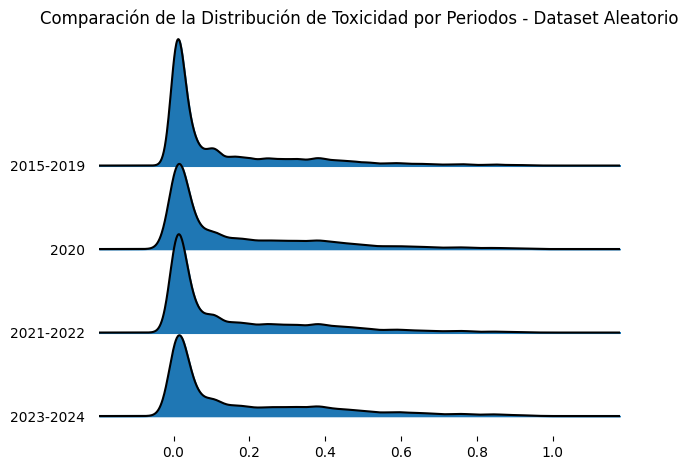

In [16]:
# Llamar a la función para crear el Joy Plot
create_joy_plot(datasets_e, labels, "Comparación de la Distribución de Toxicidad por Periodos - Dataset Aleatorio")

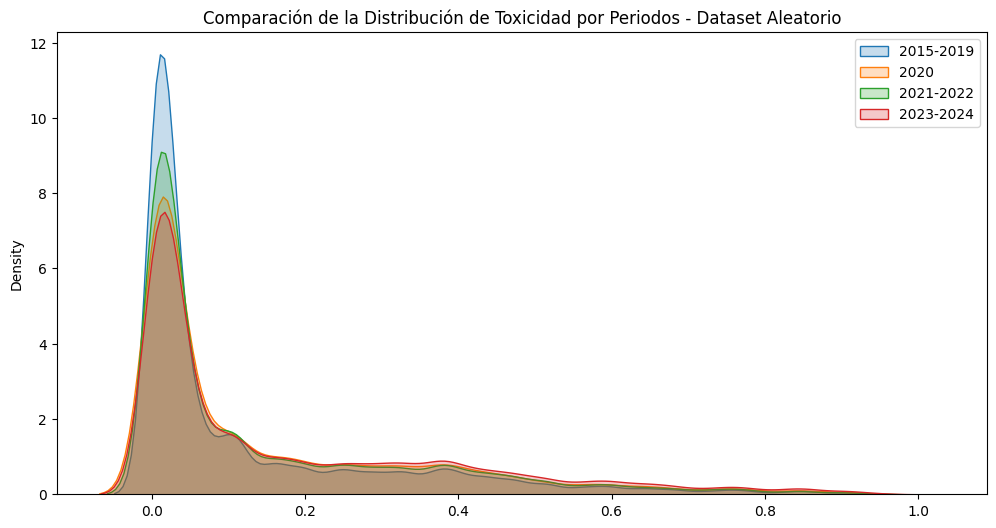

In [17]:
from scipy.stats import gaussian_kde

# Crear el Joyplot
plt.figure(figsize=(12, 6))
sns.kdeplot(datasets_e[0], fill=True, label=labels[0])
sns.kdeplot(datasets_e[1], fill=True, label=labels[1])
sns.kdeplot(datasets_e[2], fill=True, label=labels[2])
sns.kdeplot(datasets_e[3], fill=True, label=labels[3])

# Añadir líneas y anotaciones para cada pico
for i, distribucion in enumerate(datasets_e):
    kde = gaussian_kde(distribucion)  # Estimación de la densidad
    x_values = np.linspace(min(distribucion), max(distribucion), 1000)
    y_values = kde(x_values)
    
    # Encontrar el valor máximo (pico) y su índice
    peak_index = np.argmax(y_values)
    peak_value = x_values[peak_index]
    
    # Añadir la línea vertical en el pico
    #plt.axvline(peak_value, linestyle='--', color='black')  # Línea vertical
    
    # Añadir la anotación con el valor del pico
    #plt.text(peak_value + 0.02, max(y_values) * 0.9, f'Pico: {peak_value:.2f}', color='black')

# Títulos y leyenda
plt.title('Comparación de la Distribución de Toxicidad por Periodos - Dataset Aleatorio')
plt.legend()
plt.show()


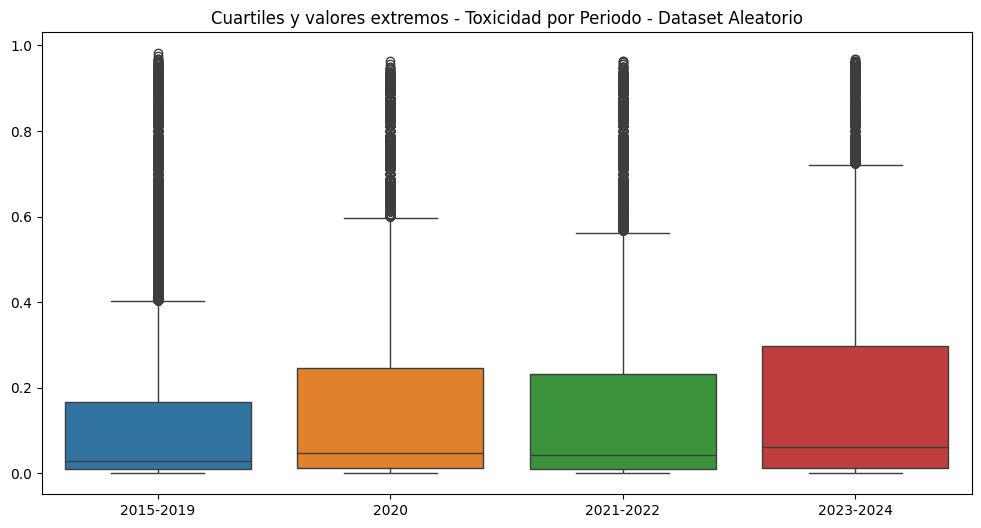

In [18]:
# Crear un boxplot para la toxicidad por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=datasets_e)
plt.title('Cuartiles y valores extremos - Toxicidad por Periodo - Dataset Aleatorio')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)  
plt.show()

### Dataset Tóxico Colectivo

Sacamos los tuits tóxicos por periodos del dataset Aleatorio 

In [19]:
df_2015_2019_t_o, df_2020_t_o, df_2021_2022_t_o, df_2023_2024_t_o = filter_toxicity(df_orgullo, 'toxicity', threshold_toxicity)

Juntamos en una lista de listas los valores de toxicidad y las etiquetas para cada periodo

In [20]:
datasets_o = [
    df_2015_2019_o['toxicity'].values,  # Dataset 1
    df_2020_o['toxicity'].values,       # Dataset 2
    df_2021_2022_o['toxicity'].values,  # Dataset 3
    df_2023_2024_o['toxicity'].values   # Dataset 4
]

datasets_t_o = [
    df_2015_2019_t_o['toxicity'].values,  # Dataset 1
    df_2020_t_o['toxicity'].values,       # Dataset 2
    df_2021_2022_t_o['toxicity'].values,  # Dataset 3
    df_2023_2024_t_o['toxicity'].values   # Dataset 4
]

labels = ['2015-2019', '2020', '2021-2022', '2023-2024']  # Etiquetas para los datasets

Calculamos la independencia con respecto al atributo toxicidad de los datasets tóxicos (toxicidad > 0.7) por periodos

In [21]:
compare_datasets_with_ks(datasets_o, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.0
Comparación entre 2015-2019 y 2021-2022: p-valor = 3.764894154822262e-18
Comparación entre 2015-2019 y 2023-2024: p-valor = 0.0
Comparación entre 2020 y 2021-2022: p-valor = 0.0
Comparación entre 2020 y 2023-2024: p-valor = 5.200211770254193e-222
Comparación entre 2021-2022 y 2023-2024: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


Cuartiles perceptiles

In [22]:
calcular_cuantiles(datasets_o, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.05
  - Mediana (50%): 0.20
  - Cuartil 75%: 0.40
  - Percentil 90%: 0.63
  - Percentil 95%: 0.77
  - Percentil 99%: 0.92
  - Moda: 0.25
  - Media: 0.26


Resultados para 2020:
  - Cuartil 25%: 0.10
  - Mediana (50%): 0.25
  - Cuartil 75%: 0.41
  - Percentil 90%: 0.61
  - Percentil 95%: 0.75
  - Percentil 99%: 0.90
  - Moda: 0.25
  - Media: 0.28


Resultados para 2021-2022:
  - Cuartil 25%: 0.05
  - Mediana (50%): 0.20
  - Cuartil 75%: 0.40
  - Percentil 90%: 0.60
  - Percentil 95%: 0.75
  - Percentil 99%: 0.90
  - Moda: 0.25
  - Media: 0.26


Resultados para 2023-2024:
  - Cuartil 25%: 0.10
  - Mediana (50%): 0.28
  - Cuartil 75%: 0.46
  - Percentil 90%: 0.71
  - Percentil 95%: 0.84
  - Percentil 99%: 0.93
  - Moda: 0.38
  - Media: 0.31




Gráficos de la densidad de tuits tóxicos - comparativa por años

<Figure size 1000x800 with 0 Axes>

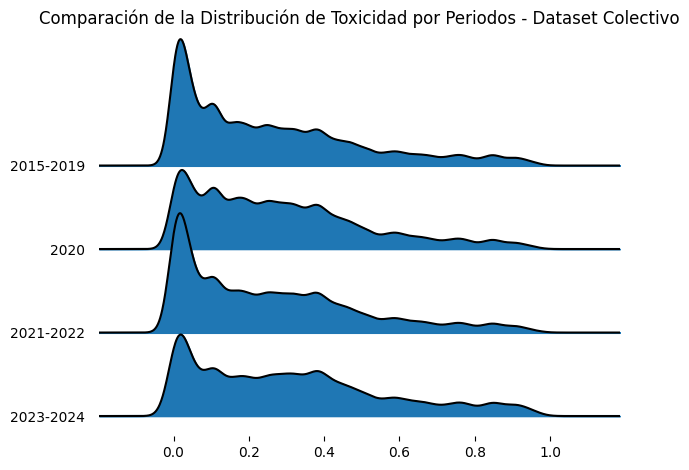

In [23]:
# Llamar a la función para crear el Joy Plot
create_joy_plot(datasets_o, labels, "Comparación de la Distribución de Toxicidad por Periodos - Dataset Colectivo")

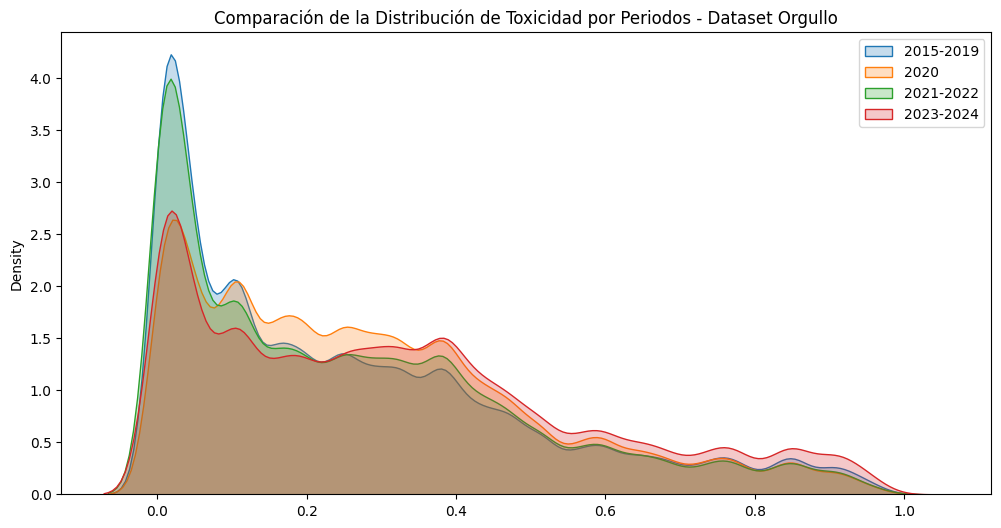

In [24]:
from scipy.stats import gaussian_kde

# Crear el Joyplot
plt.figure(figsize=(12, 6))
sns.kdeplot(datasets_o[0], fill=True, label=labels[0])
sns.kdeplot(datasets_o[1], fill=True, label=labels[1])
sns.kdeplot(datasets_o[2], fill=True, label=labels[2])
sns.kdeplot(datasets_o[3], fill=True, label=labels[3])

# Añadir líneas y anotaciones para cada pico
for i, distribucion in enumerate(datasets_o):
    kde = gaussian_kde(distribucion)  # Estimación de la densidad
    x_values = np.linspace(min(distribucion), max(distribucion), 1000)
    y_values = kde(x_values)
    
    # Encontrar el valor máximo (pico) y su índice
    peak_index = np.argmax(y_values)
    peak_value = x_values[peak_index]
    
    # Añadir la línea vertical en el pico
    #plt.axvline(peak_value, linestyle='--', color='black')  # Línea vertical
    
    # Añadir la anotación con el valor del pico
    #plt.text(peak_value + 0.02, max(y_values) * 0.9, f'Pico: {peak_value:.2f}', color='black')

# Títulos y leyenda
plt.title('Comparación de la Distribución de Toxicidad por Periodos - Dataset Orgullo')
plt.legend()
plt.show()


Observamos que de hecho la división por periodos establecida tiene sentido

<Figure size 1000x800 with 0 Axes>

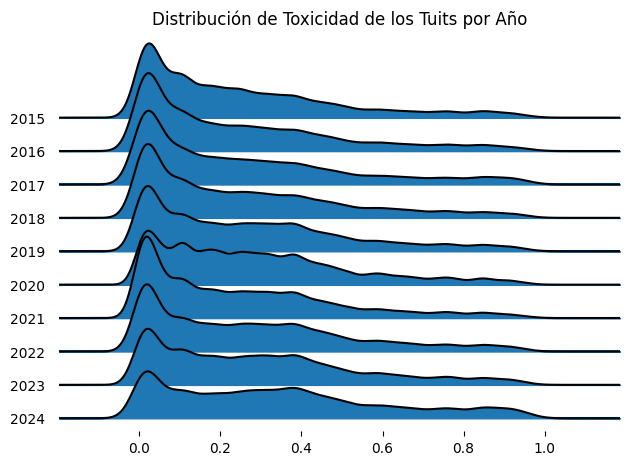

In [25]:
distribuciones_toxicidad = [df_orgullo[df_orgullo['year'] == year]['toxicity'].values for year in df_orgullo['year'].unique()]

# Crear el gráfico de distribuciones superpuestas con JoyPy
plt.figure(figsize=(10, 8))  # Tamaño del gráfico
joypy.joyplot(distribuciones_toxicidad, 
        labels=[str(year) for year in df_orgullo['year'].unique()],  # Etiquetas de los años
        title="Distribución de Toxicidad de los Tuits por Año")  # Título del gráfico

# Mostrar el gráfico
plt.show()

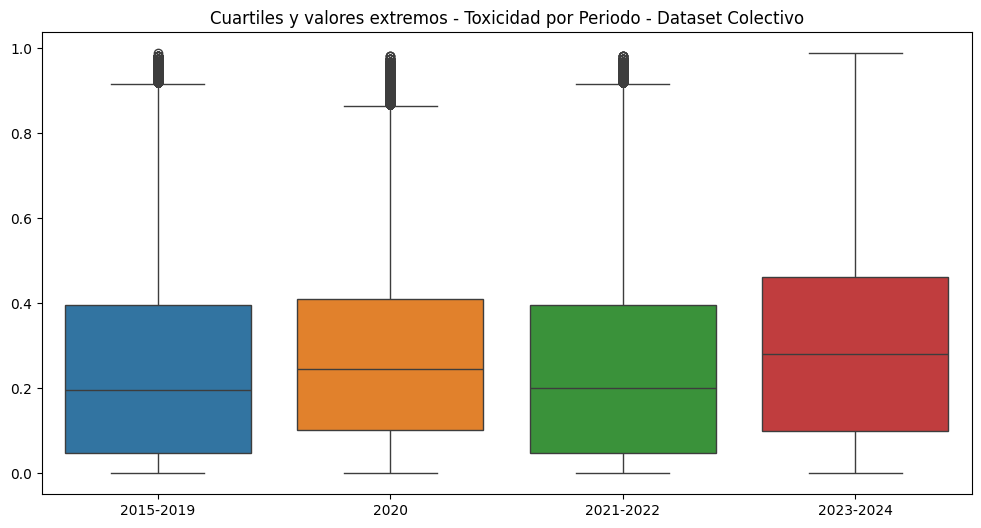

In [26]:
# Crear un boxplot para la toxicidad por día
plt.figure(figsize=(12, 6))
sns.boxplot(data=datasets_o)
plt.title('Cuartiles y valores extremos - Toxicidad por Periodo - Dataset Colectivo')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)  
plt.show()

De hecho, calcular el área azul de cada año para los valores entre 0.7 y 1 equivale al porcentaje de tuits que superan 0.7 partido por el total de tuits (para cada año)

In [27]:
calcular_cuantiles(datasets_t_o, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.76
  - Mediana (50%): 0.83
  - Cuartil 75%: 0.89
  - Percentil 90%: 0.92
  - Percentil 95%: 0.94
  - Percentil 99%: 0.96
  - Moda: 0.85
  - Media: 0.83


Resultados para 2020:
  - Cuartil 25%: 0.76
  - Mediana (50%): 0.82
  - Cuartil 75%: 0.87
  - Percentil 90%: 0.92
  - Percentil 95%: 0.94
  - Percentil 99%: 0.96
  - Moda: 0.85
  - Media: 0.82


Resultados para 2021-2022:
  - Cuartil 25%: 0.76
  - Mediana (50%): 0.83
  - Cuartil 75%: 0.88
  - Percentil 90%: 0.92
  - Percentil 95%: 0.94
  - Percentil 99%: 0.96
  - Moda: 0.85
  - Media: 0.82


Resultados para 2023-2024:
  - Cuartil 25%: 0.77
  - Mediana (50%): 0.84
  - Cuartil 75%: 0.90
  - Percentil 90%: 0.93
  - Percentil 95%: 0.94
  - Percentil 99%: 0.96
  - Moda: 0.85
  - Media: 0.83




In [28]:
calcular_cuantiles(datasets_t_e, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.75
  - Mediana (50%): 0.79
  - Cuartil 75%: 0.85
  - Percentil 90%: 0.90
  - Percentil 95%: 0.92
  - Percentil 99%: 0.94
  - Moda: 0.75
  - Media: 0.81


Resultados para 2020:
  - Cuartil 25%: 0.75
  - Mediana (50%): 0.79
  - Cuartil 75%: 0.85
  - Percentil 90%: 0.90
  - Percentil 95%: 0.91
  - Percentil 99%: 0.94
  - Moda: 0.75
  - Media: 0.80


Resultados para 2021-2022:
  - Cuartil 25%: 0.75
  - Mediana (50%): 0.78
  - Cuartil 75%: 0.85
  - Percentil 90%: 0.90
  - Percentil 95%: 0.92
  - Percentil 99%: 0.93
  - Moda: 0.75
  - Media: 0.80


Resultados para 2023-2024:
  - Cuartil 25%: 0.75
  - Mediana (50%): 0.80
  - Cuartil 75%: 0.85
  - Percentil 90%: 0.90
  - Percentil 95%: 0.92
  - Percentil 99%: 0.95
  - Moda: 0.75
  - Media: 0.81




### Comparaciones

In [29]:
threshold_notoxicity = 0.05

# Filtrar los tuits tóxicos (toxicidad > 0.7)
df_not_e = df_espanol[df_espanol['toxicity'] < threshold_notoxicity]

# Calcular el número de tuits tóxicos y el total de tuits por año - Dataset Español
toxic_tweets_per_year_noe= df_not_e.groupby('year').size()
total_tweets_per_year_noe = df_espanol.groupby('year').size()

# Filtrar los tuits tóxicos (toxicidad > 0.7)
df_not = df_orgullo[df_orgullo['toxicity'] < threshold_notoxicity]

# Calcular el número de tuits tóxicos y el total de tuits por año
toxic_tweets_per_year_no = df_not.groupby('year').size()
total_tweets_per_year_no = df_orgullo.groupby('year').size()

# Visibilidad / Interacciones

### Datasets generales Colectivo y Aleatorio

En primer lugar vemos que son independientes con respecto a los likes y retuits

In [30]:
datasets_o_like = [
    df_2015_2019_o['likeCount'].values,  # Dataset 1
    df_2020_o['likeCount'].values,       # Dataset 2
    df_2021_2022_o['likeCount'].values,  # Dataset 3
    df_2023_2024_o['likeCount'].values   # Dataset 4
]

datasets_e_like = [
    df_2015_2019_e['likeCount'].values,  # Dataset 1
    df_2020_e['likeCount'].values,       # Dataset 2
    df_2021_2022_e['likeCount'].values,  # Dataset 3
    df_2023_2024_e['likeCount'].values   # Dataset 4
]

In [31]:
calcular_cuantiles(datasets_o_like, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 6.00
  - Percentil 95%: 13.00
  - Percentil 99%: 74.00
  - Moda: 0.00
  - Media: 6.61


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 1.00
  - Cuartil 75%: 3.00
  - Percentil 90%: 11.00
  - Percentil 95%: 25.00
  - Percentil 99%: 166.00
  - Moda: 0.00
  - Media: 14.90


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 1.00
  - Cuartil 75%: 3.00
  - Percentil 90%: 11.00
  - Percentil 95%: 24.00
  - Percentil 99%: 146.00
  - Moda: 0.00
  - Media: 13.58


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 1.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 9.00
  - Percentil 95%: 23.00
  - Percentil 99%: 215.86
  - Moda: 0.00
  - Media: 21.55




In [32]:
calcular_cuantiles(datasets_e_like, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 3.00
  - Percentil 95%: 7.00
  - Percentil 99%: 37.00
  - Moda: 0.00
  - Media: 3.78


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 1.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 6.00
  - Percentil 95%: 14.00
  - Percentil 99%: 89.85
  - Moda: 0.00
  - Media: 8.33


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 1.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 7.00
  - Percentil 95%: 15.00
  - Percentil 99%: 99.00
  - Moda: 0.00
  - Media: 10.15


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 6.00
  - Percentil 95%: 16.00
  - Percentil 99%: 143.00
  - Moda: 0.00
  - Media: 13.54




In [33]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_o_like, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.0
Comparación entre 2015-2019 y 2021-2022: p-valor = 0.0
Comparación entre 2015-2019 y 2023-2024: p-valor = 0.0
Comparación entre 2020 y 2021-2022: p-valor = 0.0941725823506796
Comparación entre 2020 y 2023-2024: p-valor = 2.664496168347958e-133
Comparación entre 2021-2022 y 2023-2024: p-valor = 1.1127829738851887e-155

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


In [34]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_e_like, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.0
Comparación entre 2015-2019 y 2021-2022: p-valor = 0.0
Comparación entre 2015-2019 y 2023-2024: p-valor = 0.0
Comparación entre 2020 y 2021-2022: p-valor = 0.010153847165726248
Comparación entre 2020 y 2023-2024: p-valor = 7.711996539423683e-26
Comparación entre 2021-2022 y 2023-2024: p-valor = 1.5479597950264044e-39

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


In [35]:
datasets_o_retuit = [
    df_2015_2019_o['retweetCount'].values,  # Dataset 1
    df_2020_o['retweetCount'].values,       # Dataset 2
    df_2021_2022_o['retweetCount'].values,  # Dataset 3
    df_2023_2024_o['retweetCount'].values   # Dataset 4
]

datasets_e_retuit = [
    df_2015_2019_e['retweetCount'].values,  # Dataset 1
    df_2020_e['retweetCount'].values,       # Dataset 2
    df_2021_2022_e['retweetCount'].values,  # Dataset 3
    df_2023_2024_e['retweetCount'].values   # Dataset 4
]

In [36]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_o_retuit, labels)

Comparación entre 2015-2019 y 2020: p-valor = 1.6070653440206016e-27
Comparación entre 2015-2019 y 2021-2022: p-valor = 1.376629887592627e-06
Comparación entre 2015-2019 y 2023-2024: p-valor = 5.1914171889578956e-167
Comparación entre 2020 y 2021-2022: p-valor = 4.873214203357649e-06
Comparación entre 2020 y 2023-2024: p-valor = 5.995238057211266e-49
Comparación entre 2021-2022 y 2023-2024: p-valor = 8.164558347691899e-86

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


In [37]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_e_retuit, labels)

Comparación entre 2015-2019 y 2020: p-valor = 6.336705701268652e-08
Comparación entre 2015-2019 y 2021-2022: p-valor = 3.44372538604083e-33
Comparación entre 2015-2019 y 2023-2024: p-valor = 1.679632979752084e-91
Comparación entre 2020 y 2021-2022: p-valor = 0.004107265600705451
Comparación entre 2020 y 2023-2024: p-valor = 9.94482411014117e-21
Comparación entre 2021-2022 y 2023-2024: p-valor = 2.0119858242416153e-12

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


In [38]:
calcular_cuantiles(datasets_o_retuit, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 2.00
  - Percentil 95%: 5.00
  - Percentil 99%: 30.00
  - Moda: 0.00
  - Media: 2.48


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 2.00
  - Percentil 95%: 5.00
  - Percentil 99%: 37.00
  - Moda: 0.00
  - Media: 3.33


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 2.00
  - Percentil 95%: 5.00
  - Percentil 99%: 30.00
  - Moda: 0.00
  - Media: 2.60


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 2.00
  - Percentil 95%: 4.00
  - Percentil 99%: 42.00
  - Moda: 0.00
  - Media: 3.84




In [39]:
calcular_cuantiles(datasets_e_retuit, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 3.00
  - Percentil 99%: 17.00
  - Moda: 0.00
  - Media: 1.63


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 3.00
  - Percentil 99%: 23.00
  - Moda: 0.00
  - Media: 2.01


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 3.00
  - Percentil 99%: 19.00
  - Moda: 0.00
  - Media: 1.75


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 2.00
  - Percentil 99%: 23.00
  - Moda: 0.00
  - Media: 2.42




### Dataset Aleatorio Tóxico

In [40]:
datasets_t_e_like = [
    df_2015_2019_t_e['likeCount'].values,  # Dataset 1
    df_2020_t_e['likeCount'].values,       # Dataset 2
    df_2021_2022_t_e['likeCount'].values,  # Dataset 3
    df_2023_2024_t_e['likeCount'].values   # Dataset 4
]

In [41]:
calcular_cuantiles(datasets_t_e_like, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 3.00
  - Percentil 95%: 5.00
  - Percentil 99%: 32.00
  - Moda: 0.00
  - Media: 4.08


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 4.00
  - Percentil 95%: 9.00
  - Percentil 99%: 46.32
  - Moda: 0.00
  - Media: 33.10


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 4.00
  - Percentil 95%: 8.00
  - Percentil 99%: 54.65
  - Moda: 0.00
  - Media: 3.44


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 4.90
  - Percentil 95%: 10.00
  - Percentil 99%: 60.08
  - Moda: 0.00
  - Media: 6.58




In [42]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_t_e_like, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.0017773017368002792
Comparación entre 2015-2019 y 2021-2022: p-valor = 0.0023764440609816088
Comparación entre 2015-2019 y 2023-2024: p-valor = 0.004477968394361667
Comparación entre 2020 y 2021-2022: p-valor = 0.6824689578545495
Comparación entre 2020 y 2023-2024: p-valor = 0.07612086270563907
Comparación entre 2021-2022 y 2023-2024: p-valor = 0.8459981836876994

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


In [43]:
datasets_t_e_retuit = [
    df_2015_2019_t_e['retweetCount'].values,  # Dataset 1
    df_2020_t_e['retweetCount'].values,       # Dataset 2
    df_2021_2022_t_e['retweetCount'].values,  # Dataset 3
    df_2023_2024_t_e['retweetCount'].values   # Dataset 4
]

In [44]:
calcular_cuantiles(datasets_t_e_retuit, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 2.00
  - Percentil 99%: 11.00
  - Moda: 0.00
  - Media: 1.65


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 2.00
  - Percentil 99%: 12.00
  - Moda: 0.00
  - Media: 9.22


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 1.00
  - Percentil 99%: 5.65
  - Moda: 0.00
  - Media: 0.52


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 0.00
  - Percentil 95%: 1.00
  - Percentil 99%: 7.59
  - Moda: 0.00
  - Media: 0.67




In [45]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_t_e_retuit, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.6692055839248247
Comparación entre 2015-2019 y 2021-2022: p-valor = 0.00039133388757040823
Comparación entre 2015-2019 y 2023-2024: p-valor = 9.436187372903993e-08
Comparación entre 2020 y 2021-2022: p-valor = 0.33165092736695595
Comparación entre 2020 y 2023-2024: p-valor = 0.029703943013524785
Comparación entre 2021-2022 y 2023-2024: p-valor = 0.9429176150228191

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


### Dataset Coletivo Tóxico

In [46]:
datasets_t_o_like = [
    df_2015_2019_t_o['likeCount'].values,  # Dataset 1
    df_2020_t_o['likeCount'].values,       # Dataset 2
    df_2021_2022_t_o['likeCount'].values,  # Dataset 3
    df_2023_2024_t_o['likeCount'].values   # Dataset 4
]

In [47]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_t_o_like, labels)

Comparación entre 2015-2019 y 2020: p-valor = 6.880811807836385e-59
Comparación entre 2015-2019 y 2021-2022: p-valor = 1.0436348958983051e-34
Comparación entre 2015-2019 y 2023-2024: p-valor = 5.144148066977515e-08
Comparación entre 2020 y 2021-2022: p-valor = 9.144952432981804e-06
Comparación entre 2020 y 2023-2024: p-valor = 4.693585991976873e-41
Comparación entre 2021-2022 y 2023-2024: p-valor = 1.0775358417653599e-22

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


In [48]:
calcular_cuantiles(datasets_t_o_like, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 3.00
  - Percentil 95%: 6.00
  - Percentil 99%: 31.00
  - Moda: 0.00
  - Media: 2.38


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 2.00
  - Percentil 90%: 6.00
  - Percentil 95%: 14.85
  - Percentil 99%: 126.77
  - Moda: 0.00
  - Media: 12.19


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 5.00
  - Percentil 95%: 11.00
  - Percentil 99%: 65.00
  - Moda: 0.00
  - Media: 5.01


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 1.00
  - Percentil 90%: 4.00
  - Percentil 95%: 9.00
  - Percentil 99%: 60.96
  - Moda: 0.00
  - Media: 8.84




In [49]:
datasets_t_o_retuit = [
    df_2015_2019_t_o['retweetCount'].values,  # Dataset 1
    df_2020_t_o['retweetCount'].values,       # Dataset 2
    df_2021_2022_t_o['retweetCount'].values,  # Dataset 3
    df_2023_2024_t_o['retweetCount'].values   # Dataset 4
]

In [50]:
# Llamar a la función para comparar los datasets
compare_datasets_with_ks(datasets_t_o_retuit, labels)

Comparación entre 2015-2019 y 2020: p-valor = 0.08586254260225634
Comparación entre 2015-2019 y 2021-2022: p-valor = 0.0002125493326475144
Comparación entre 2015-2019 y 2023-2024: p-valor = 5.164549078503597e-17
Comparación entre 2020 y 2021-2022: p-valor = 0.00018524074752249728
Comparación entre 2020 y 2023-2024: p-valor = 2.3554774787133117e-14
Comparación entre 2021-2022 y 2023-2024: p-valor = 0.009951009632574207

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


In [51]:
calcular_cuantiles(datasets_t_o_retuit, labels)

Resultados para 2015-2019:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 2.00
  - Percentil 99%: 9.00
  - Moda: 0.00
  - Media: 0.72


Resultados para 2020:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 2.00
  - Percentil 99%: 23.00
  - Moda: 0.00
  - Media: 2.60


Resultados para 2021-2022:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 1.00
  - Percentil 95%: 1.00
  - Percentil 99%: 10.00
  - Moda: 0.00
  - Media: 0.71


Resultados para 2023-2024:
  - Cuartil 25%: 0.00
  - Mediana (50%): 0.00
  - Cuartil 75%: 0.00
  - Percentil 90%: 0.00
  - Percentil 95%: 1.00
  - Percentil 99%: 8.00
  - Moda: 0.00
  - Media: 0.88




colectivo vs aleatorio likes

In [52]:
compare_datasets_with_ks([df_orgullo['likeCount'].values, df_espanol['likeCount'].values], ['colectivo', 'aleatorio'])

Comparación entre colectivo y aleatorio: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


colectivo vs aleatorio retuits

In [53]:
compare_datasets_with_ks([df_orgullo['retweetCount'].values, df_espanol['retweetCount'].values], ['colectivo', 'aleatorio'])

Comparación entre colectivo y aleatorio: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


In [54]:
toxicos_c = df_orgullo[df_orgullo['toxicity'] > 0.7]
toxicos_e = df_espanol[df_espanol['toxicity'] > 0.7]

colectivo tóxico vs aleatorio tóxico likes

In [55]:
compare_datasets_with_ks([toxicos_c['likeCount'].values, toxicos_e['likeCount'].values], ['colectivo tóxico', 'aleatorio tóxico'])

Comparación entre colectivo tóxico y aleatorio tóxico: p-valor = 0.18637183568233473

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


colectivo tóxico vs aleatorio tóxico retuits

In [56]:
compare_datasets_with_ks([toxicos_c['retweetCount'].values, toxicos_e['retweetCount'].values], ['colectivo tóxico', 'aleatorio tóxico'])

Comparación entre colectivo tóxico y aleatorio tóxico: p-valor = 0.994855924412783

Al menos un p-valor es mayor o igual a 0.01. Los datasets no son completamente independientes entre sí.


colectivo tóxico vs colectivo likes

In [57]:
compare_datasets_with_ks([toxicos_c['likeCount'].values, df_orgullo['likeCount'].values], ['colectivo tóxico', 'colectivo'])

Comparación entre colectivo tóxico y colectivo: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


colectivo tóxico vs colectivo retuits

In [58]:
compare_datasets_with_ks([toxicos_c['retweetCount'].values, df_orgullo['retweetCount'].values], ['colectivo tóxico', 'colectivo'])

Comparación entre colectivo tóxico y colectivo: p-valor = 0.0

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


aleatorio vs aleatorio tóxico likes

In [59]:
compare_datasets_with_ks([df_espanol['likeCount'].values, toxicos_e['likeCount'].values], ['aleatorio', 'aleatorio tóxico'])

Comparación entre aleatorio y aleatorio tóxico: p-valor = 7.051139113305365e-28

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.


aleatorio vs aleatorio tóxico retuits

In [60]:
compare_datasets_with_ks([df_espanol['retweetCount'].values, toxicos_e['retweetCount'].values], ['aleatorio', 'aleatorio tóxico'])

Comparación entre aleatorio y aleatorio tóxico: p-valor = 3.576484289697725e-10

Todos los p-valores son menores que 0.01. Los datasets son independientes entre sí.
